In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import pickle
from gprofiler import GProfiler

# scTRS tools
import scTRS.util as util
import scTRS.data_loader as dl
import scTRS.method as md
from scTRS.method import get_p_from_empi_null

from os.path import join

# autoreload
%load_ext autoreload
%autoreload 2
# logging
sc.logging.print_header()

scanpy==1.6.0 anndata==0.7.4 umap==0.4.6 numpy==1.19.2 scipy==1.5.2 pandas==1.1.2 scikit-learn==0.23.2 statsmodels==0.12.0 python-igraph==0.8.3 leidenalg==0.8.2


In [2]:
# Setup file paths
DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data'
GENE_SCORE_PATH = join(DATA_PATH, 'trs_gene_scores')
hsapiens_mmusculus_mapping = pd.read_csv(join(GENE_SCORE_PATH, 'meta_data', 'hsapiens_mmusculus_mapping.csv'))
data_facs_ct = dl.load_tms_ct(DATA_PATH, data_name='facs')

/n/holystore01/LABS/price_lab/Users/khou/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/n/holystore01/LABS/price_lab/Users/khou/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Trying to set attribute `.obs` of view, copying.


In [3]:
def load_gene_score(path, gene_id_col, score_col, ascending=True, num_genes=None, hsapiens_mmusculus_mapping=None):
    """load gene score from file and sort 
    Args:
        path: the file path to the gene score, in csv format
        gene_id_col: the column corresponding the gene identifier
        score_col: the column corresponding to the gene score
        ascending: whether to rank genes by score in ascending order
        convert_mmusculus: whether to convert to mmusculus gene symbols, input a dataframe if needed
        
    Returns:
        gene_score (pd.DataFrame): a dataframe with sorted scores
    """
    df = pd.read_csv(path, usecols=[gene_id_col, score_col])
    df.columns =['GENE', 'SCORE']
    if hsapiens_mmusculus_mapping is not None:
        df = pd.merge(df, hsapiens_mmusculus_mapping, left_on='GENE', right_on='hsapiens')[['mmusculus', 'SCORE']].rename(columns={'mmusculus': 'GENE'})
    df = df.sort_values('SCORE', ascending=ascending)
    if num_genes is not None:
        df = df.iloc[0 : num_genes, :].reset_index(drop=True)
    return df

def zsc2pval(zsc):
    return 1 - sp.stats.norm.cdf(zsc)


np.random.seed(1234)
gene_set_dict = dict()

## generate gene sets
trait_list = ['PASS_Schizophrenia_Ruderfer2018',
              'PASS_BipolarDisorder_Ruderfer2018',
              'PASS_Alzheimers_Jansen2019', 
              'PASS_AdultOnsetAsthma_Ferreira2019',
              'PASS_Coronary_Artery_Disease', 
              'PASS_LargeArteryStroke_Malik2018', 
              'PASS_HDL', 'PASS_LDL',
              'PASS_Rheumatoid_Arthritis', 'PASS_Lupus', 
              'PASS_FastingGlucose_Manning',
              'PASS_IBD_deLange2017', 
              'PASS_Type_1_Diabetes', 
              'PASS_Type_2_Diabetes']


GENE_SCORE_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/trs_gene_scores'
hsapiens_mmusculus_mapping = pd.read_csv(join(GENE_SCORE_PATH, 'meta_data', 'hsapiens_mmusculus_mapping.csv'))

            
for trait in trait_list:
    # trait gene set
    trait_gene_df = load_gene_score(path=join(GENE_SCORE_PATH, 'gwas_max_abs_z', f'{trait}.csv'),
                     gene_id_col='GENE',
                     score_col='MAX_ABS_Z',
                     ascending=False,
                     num_genes=500,
                     hsapiens_mmusculus_mapping=hsapiens_mmusculus_mapping)

    gene_set_dict[trait] = np.unique(trait_gene_df.GENE.values)

for i in range(1, 6):
    gene_set_dict[f'random_{i}'] = np.unique(list(np.random.choice(data_facs_ct.var_names, size=500, replace=False)))

for name in gene_set_dict:
    gene_set_dict[name] = list(set(gene_set_dict[name]) & set(data_facs_ct.var_names))

In [4]:
def normalize_across_dataset(dic_trs):
    ctrl_keys = [name for name in dic_trs if name.startswith('trs_ctrl') and name.endswith('_z')]
    ctrl_trs = [dic_trs[k] for k in ctrl_keys]
    trs_z = dic_trs['trs_z']
    trs_z = (trs_z - trs_z.mean()) / trs_z.std()
    ctrl_trs = [(t - t.mean()) / t.std() for t in ctrl_trs]
    normal_trs_ep = get_p_from_empi_null(trs_z, np.concatenate(ctrl_trs))
    return normal_trs_ep

def score_cell_wrapper(gene_list, num_ctrl, out):
    DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data'
    GENE_SCORE_PATH = join(DATA_PATH, 'trs_gene_scores')
    hsapiens_mmusculus_mapping = pd.read_csv(join(GENE_SCORE_PATH, 'meta_data', 'hsapiens_mmusculus_mapping.csv'))
    data_facs_ct = dl.load_tms_ct(DATA_PATH, data_name='facs')
    
    dic_trs = md.score_cell(data_facs_ct, gene_list, suffix='',
              ctrl_opt='mean_match', trs_opt='vst', bc_opt='debug',
              n_ctrl=num_ctrl, n_genebin=200, cov_list=None,
              return_list=['trs', 'trs_ep', 'trs_ez'], verbose=False)
    
    trs_ep = data_facs_ct.obs['trs_ep'].values.copy()
    norm_trs_ep = normalize_across_dataset(dic_trs)
    rls = {'trs_ep': trs_ep, 'norm_trs_ep': norm_trs_ep}
    with open(out, 'wb') as f:
        pickle.dump(rls, f)


In [14]:
import submitit
import itertools

def param2out(param):
    return '.'.join([str(p) for p in param])

param_list = [param for param in itertools.product(list(gene_set_dict.keys()), [100, 500])]
executor = submitit.AutoExecutor(folder="~/submitit_log/")
executor.update_parameters(timeout_min=30, mem_gb=20, slurm_partition="shared")
expr_dir = "/n/home12/khou/scTRS_results/121120_score_comparison/"
if not os.path.exists(expr_dir):
    os.makedirs(expr_dir)
    
todo_param_list = [param for param in param_list if not os.path.exists(join(expr_dir, param2out(param) + '.pkl'))]
job_dict = {param: executor.submit(score_cell_wrapper, gene_set_dict[param[0]], param[1], join(expr_dir, param2out(param) + '.pkl')) 
            for param in todo_param_list}

In [20]:
result_dict = {}
for param in param_list:
    path = join(expr_dir, param2out(param) + '.pkl')
    if os.path.exists(path):
        with open(path, 'rb') as f:
            result_dict[param] = pickle.load(f)
    else:
        print(f'{path} does not exist')

# p-value calibration

In [62]:
df = []
for i in range(1, 6):
    for opt in ['trs_ep', 'norm_trs_ep']:
        for num_ctrl in [100, 500]:
            pval = result_dict[(f'random_{i}', num_ctrl)][opt]
            sig_prop = [np.mean(pval < 5 * 10 ** (-cutoff)) for cutoff in [2, 3, 4]]
            sig_prop = [f'{s:.1e}' for s in sig_prop]
            df.append([i, opt, num_ctrl, *sig_prop])
df = pd.DataFrame(df, columns=['Random run', 'option', 'num_ctrl', '5e-2', '5e-3', '5e-4'])
df

,Random run,option,num_ctrl,5e-2,5e-3,5e-4
0,1,trs_ep,100,5.7e-02,8.6e-03,1.5e-03
1,1,trs_ep,500,5.7e-02,7.6e-03,8.5e-04
2,1,norm_trs_ep,100,5.1e-02,7.3e-03,1.2e-03
3,1,norm_trs_ep,500,5.2e-02,6.7e-03,7.3e-04
4,2,trs_ep,100,3.8e-02,3.3e-03,3.1e-04
5,2,trs_ep,500,3.6e-02,2.8e-03,1.6e-04
6,2,norm_trs_ep,100,5.0e-02,5.8e-03,6.8e-04
7,2,norm_trs_ep,500,4.9e-02,5.1e-03,4.3e-04
8,3,trs_ep,100,3.8e-02,3.5e-03,4.6e-04
9,3,trs_ep,500,3.6e-02,2.6e-03,2.1e-04


# Find number of associated cells for each tissue/tissue_celltype

In [82]:
def plot_assoc(score_dict, adata, stratify_by):
    def num2str(x):
        if x>1000:
            return '%0.1fk'%(x/1000)
        elif x>0:
            return '%d'%x
        else:
            return ''
    
    assert stratify_by in ['tissue', 'tissue_celltype']
    stratify_list = sorted(list(set(adata.obs[stratify_by])))
    
    # make df for plotting
    df_plot = pd.DataFrame(index=stratify_list, columns=list(score_dict.keys()), data=0)
    df_obs = adata.obs.copy()

    for trait in score_dict:

        pval = score_dict[trait]
        fdr = multipletests(pval, method='fdr_bh')[1]

        # tissue
        temp_df = df_obs.loc[fdr<0.2].copy()
        temp_df = temp_df.groupby([stratify_by]).agg({'cell':len})
        temp_df = temp_df.loc[~temp_df['cell'].isna()]
        df_plot.loc[temp_df.index, trait] = temp_df['cell'].values
    

    df_plot = df_plot.loc[df_plot.max(axis=1)>10]
    df_plot = df_plot.T
    df_plot[df_plot<10] = 0

    mat_annot = np.zeros(df_plot.shape, dtype=object)
    for i_col,col in enumerate(df_plot.columns):
        mat_annot[:,i_col] = [num2str(x) for x in df_plot[col].values]
    df_plot = np.log10(df_plot+1)
    if stratify_by == 'tissue-celltype':
        plt.figure(figsize=[0.4*df_plot.shape[1]+3, 0.25*df_plot.shape[0]+2+1])
    else:
        plt.figure(figsize=[0.4*df_plot.shape[1]+3, 0.25*df_plot.shape[0]+2])
    sns.heatmap(df_plot, annot=mat_annot, fmt='s', cbar=False)
    plt.xticks(np.arange(df_plot.shape[1])+0.5, df_plot.columns, rotation=45, ha='right')
    

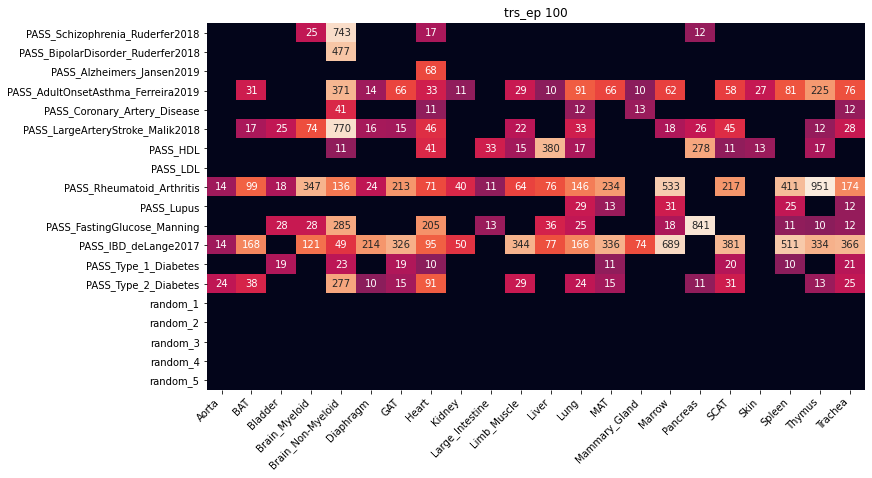

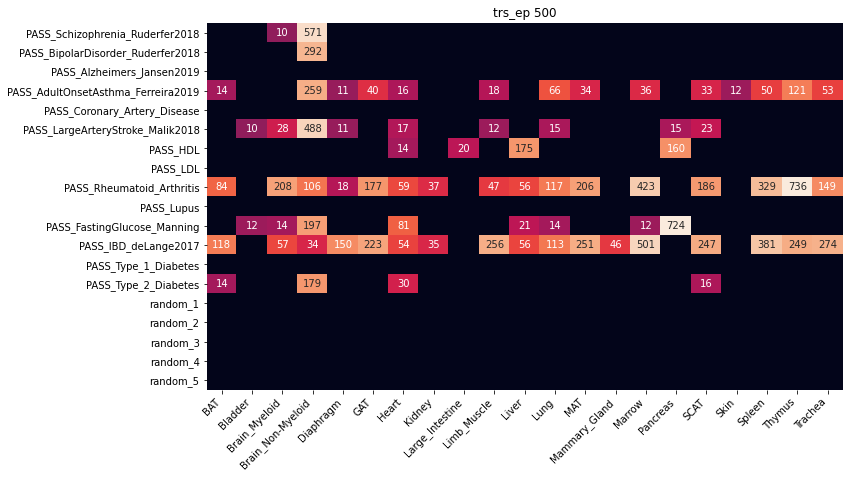

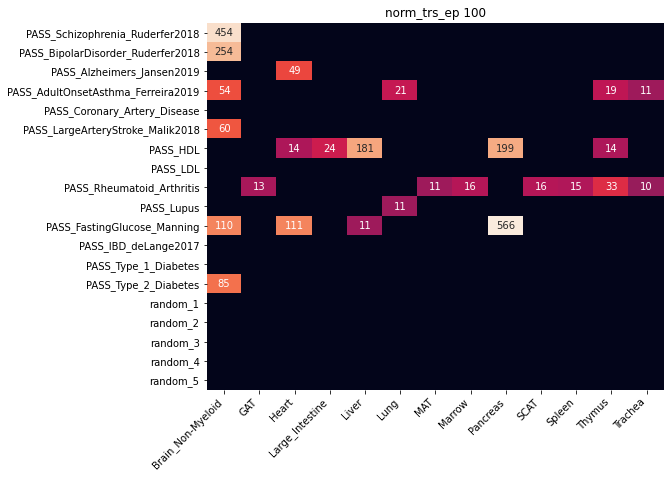

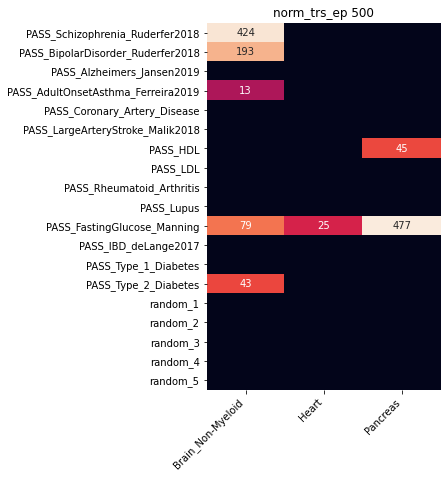

In [83]:
for opt in ['trs_ep', 'norm_trs_ep']:
    for num_ctrl in [100, 500]:
        score_dict = {trait: result_dict[(trait, num_ctrl)][opt] for trait in gene_set_dict}
        plot_assoc(score_dict, data_facs_ct, stratify_by='tissue')
        plt.title(f'{opt} {num_ctrl}')
        plt.show()